In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

# from src.pods.Pods import train
from src.hds.Hds import train
from src.env.Pendulum import InvertedPendulum
import pickle


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

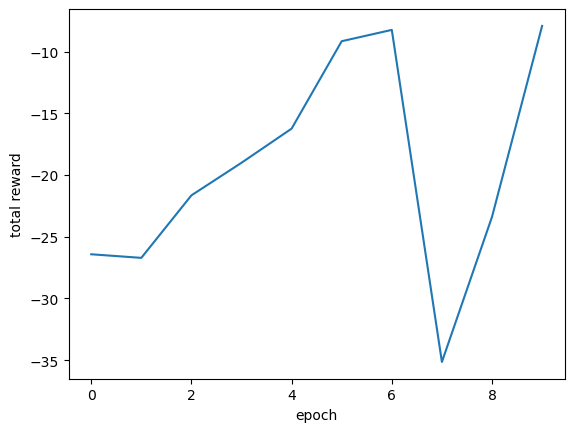

big epoch: 9 small epoch: 0 Loss 0.8824286
big epoch: 9 small epoch: 1 Loss 0.9937028
big epoch: 9 small epoch: 2 Loss 1.2564394
big epoch: 9 small epoch: 3 Loss 0.7412379
big epoch: 9 small epoch: 4 Loss 0.40737408
big epoch: 9 small epoch: 5 Loss 1.1474514
big epoch: 9 small epoch: 6 Loss 1.2312202
big epoch: 9 small epoch: 7 Loss 1.1165183
big epoch: 9 small epoch: 8 Loss 0.6844508
big epoch: 9 small epoch: 9 Loss 0.6660011
big epoch: 9 small epoch: 10 Loss 1.3313522
big epoch: 9 small epoch: 11 Loss 1.2704679
big epoch: 9 small epoch: 12 Loss 2.1970882
big epoch: 9 small epoch: 13 Loss 1.2998611
big epoch: 9 small epoch: 14 Loss 1.3558112
big epoch: 9 small epoch: 15 Loss 1.5899963
big epoch: 9 small epoch: 16 Loss 1.2103816
big epoch: 9 small epoch: 17 Loss 0.58471555
big epoch: 9 small epoch: 18 Loss 1.6282966
big epoch: 9 small epoch: 19 Loss 0.89509434


In [4]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train(env,trajectory_length=10 ,num_samples=16,epochs=10, inner_epochs=20, alpha_a=5e-3, init_learning_rate=1e-2, lambda_policy_update=0.05, progress_fn=progress_f)
# policy = train(env,trajectory_length=50 ,num_samples=16,epochs=20, alpha_a=2e-5, progress_fn=progress_f)

In [5]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.25577638]
[0.2555317]
[0.25564152]
[0.25609145]
[0.25627717]
[0.2563052]
[0.25630707]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]
[0.2563071]

In [6]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)